# Разработка A/B-тестирования и анализ результатов

Продукт: приложение с бесконечной лентой и короткими видео.

Ситуация: проверка эффективности нового алгаритма рекомендательной системы.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Задача: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

In [3]:
top_user_id = sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending=False).reset_index()['user_id'][0]
top_sessions_user = sessions_history[sessions_history['user_id'] == top_user_id]
top_sessions_user

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

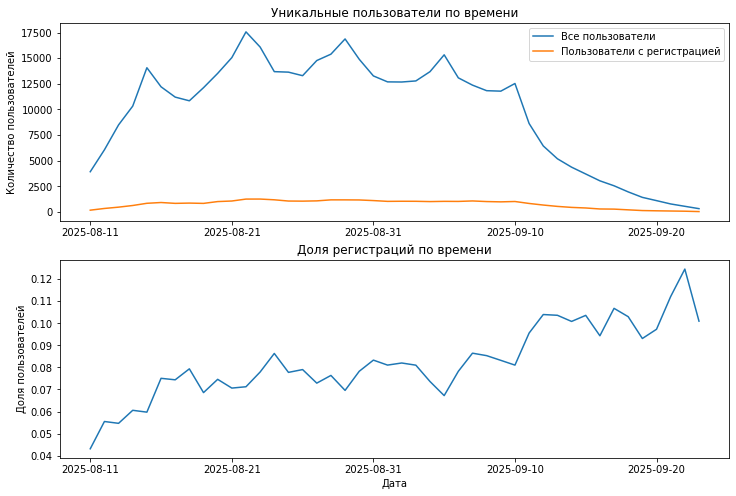

In [4]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
users_per_day = sessions_history.groupby('session_date')['user_id'].nunique()
users_per_day.plot(kind='line', label='Все пользователи')
reg_users_per_day = sessions_history[sessions_history['registration_flag']==1].groupby('session_date')['user_id'].nunique()
reg_users_per_day.plot(kind='line', label='Пользователи с регистрацией')
plt.title('Уникальные пользователи по времени')
plt.xlabel('')
plt.ylabel('Количество пользователей')
plt.legend()
plt.subplot(2,1,2)
reg_users_share = reg_users_per_day/users_per_day
reg_users_share.plot(kind='line', label='Пользователи с регистрацией')
plt.title('Доля регистраций по времени')
plt.xlabel('Дата')
plt.ylabel('Доля пользователей')
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Найдем количество сессий для каждого значения количества просмотренных страниц. Построим столбчатую диаграмму.

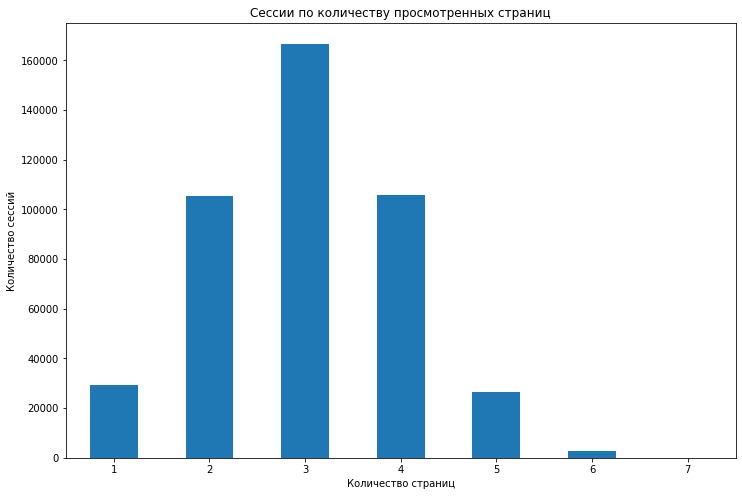

In [5]:
sessions_by_pages = sessions_history.groupby('page_counter')['session_id'].count()
plt.figure(figsize=(12,8))
sessions_by_pages.plot(kind='bar')
plt.title('Сессии по количеству просмотренных страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Количество сессий')
plt.xticks(rotation=0)
plt.show()

#### 1.5. Доля пользователей, просмотревших четыре и более страницы
Построим график со средним значением доли успешных сессий (с просмотром 4 и более страниц) от всех сессий по дням за весь период наблюдения.

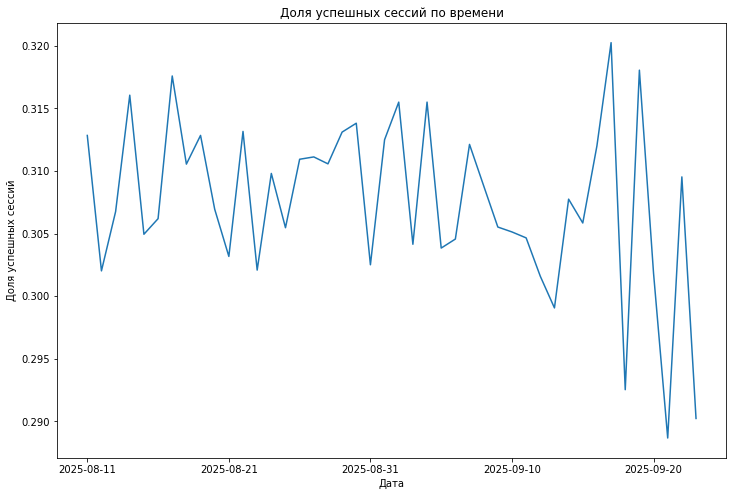

In [6]:
sessions_history['good_session'] = sessions_history['page_counter'] >= 4
good_share = sessions_history.groupby('session_date')['good_session'].mean()
plt.figure(figsize=(12,8))
good_share.plot(kind='line')
plt.title('Доля успешных сессий по времени')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.show()

### 2. Подготовка к тесту

#### 2.1 Формулировка нулевой и альтернативной гипотез


Сформулируем нулевую и альтернативную гипотезы:






**H0**: Новый алгоритм рекомендательных систем не повлияет на долю успешных сессий.

**H1**: Новый алгоритм рекомендательных систем позволит увеличить долю успешных сессий.

#### 2.2. Расчёт размера выборки
Рассчитаем необходимое для эксперимента количество пользователей

In [7]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения.

In [8]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = users_per_day.mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

Рассчитаем процентную разницу в количестве пользователей в группах A и B.

In [9]:
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [10]:
ab_users = sessions_test_part.groupby('test_group')['user_id'].nunique()
ab_users

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [11]:
ab_users['B']

1466

In [12]:
delta = round((ab_users['A'] - ab_users['B'])/ab_users['A']*100, 2)
print(f'В группе A количество пользователей отличается от группы B на {delta}%')

В группе A количество пользователей отличается от группы B на 0.74%


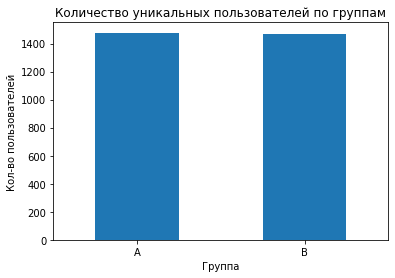

In [13]:
ab_users.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Количество уникальных пользователей по группам')
plt.xlabel('Группа')
plt.ylabel('Кол-во пользователей')
plt.show()

#### 3.2. Проверка пересечений пользователей
Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B и убедимся, что таких нет.

In [14]:
len(set(sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].to_list()) & set(sessions_test_part[sessions_test_part['test_group']=='B']['user_id'].to_list()))

0

Группы независимы

#### 3.3. Равномерность разделения пользователей по устройствам
Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

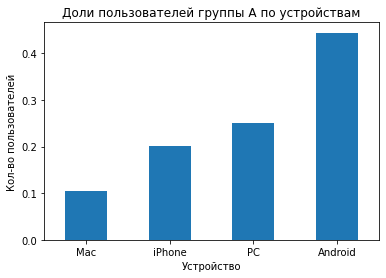

In [15]:
n_users_a = sessions_test_part['user_id'][sessions_test_part['test_group']=='A'].nunique()
(sessions_test_part[sessions_test_part['test_group']=='A'].groupby('device')['user_id'].nunique()/n_users_a).sort_values().plot(kind='bar')
plt.title('Доли пользователей группы А по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=0)
plt.show()

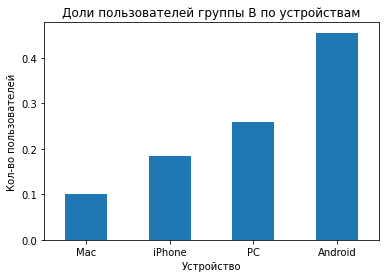

In [16]:
n_users_b = sessions_test_part['user_id'][sessions_test_part['test_group']=='B'].nunique()
(sessions_test_part[sessions_test_part['test_group']=='B'].groupby('device')['user_id'].nunique()/n_users_b).sort_values().plot(kind='bar')
plt.title('Доли пользователей группы B по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=0)
plt.show()

Получили 2 идентичных графика.

#### 3.4. Равномерность распределения пользователей по регионам
Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

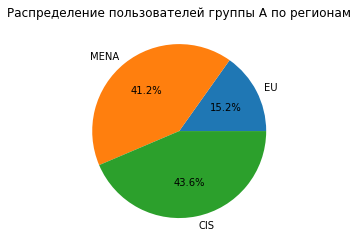

In [17]:
users_per_region_a = sessions_test_part[sessions_test_part['test_group']=='A'].groupby('region')['user_id'].nunique().sort_values().reset_index()
plt.pie(users_per_region_a['user_id'], labels=users_per_region_a['region'], autopct='%.1f%%')
plt.title('Распределение пользователей группы А по регионам')
plt.ylabel('')
plt.show()

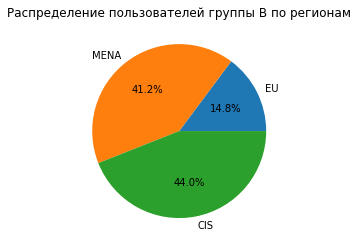

In [18]:
users_per_region_b = sessions_test_part[sessions_test_part['test_group']=='B'].groupby('region')['user_id'].nunique().sort_values().reset_index()
plt.pie(users_per_region_b['user_id'], labels=users_per_region_b['region'], autopct='%.1f%%')
plt.title('Распределение пользователей группы B по регионам')
plt.ylabel('')
plt.show()

Графики снова показали одинаковый результат

#### 3.5. Вывод после проверки A/B-теста

- При проверке различие в количестве пользователей по группам оказалось несущественным (менее 1%).
- Пересечение пользователей не обнаружено.
- Распределения по категориальным переменным также различаются несущественно.

Таким образом, нарушений в распределении по группам не выявлено, A/B-тест проверку прошел.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики
- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [19]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')
sessions_test['good_session'] = sessions_test['page_counter'] >= 4

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

In [20]:
a_metric = sessions_test[sessions_test['test_group']=='A'].groupby('session_date')['session_id'].nunique()
b_metric = sessions_test[sessions_test['test_group']=='B'].groupby('session_date')['session_id'].nunique()
stat_ttest, p_value_ttest = ttest_ind(a_metric, b_metric, equal_var=True, alternative='two-sided')
p_value_ttest

0.938219304859116

Нулевая гипотеза не отвергается даже на уровне значимости 10%. Можно говорить о том, что существенных различий в выборках нет.

#### 4.3. Сравнение доли успешных сессий

Можно переходить к анализу ключевой метрики — доли успешных сессий.

In [21]:
a_good_share = sessions_test[sessions_test['test_group']=='A']['good_session'].mean()
b_good_share = sessions_test[sessions_test['test_group']=='B']['good_session'].mean()
print(a_good_share)
print(b_good_share)
print(a_good_share - b_good_share)

0.3077233557344958
0.31828992745867524
-0.010566571724179463


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной.

Проверим, является ли изменение в метрике доли успешных сессий статистически значимым.

In [22]:
n_a = sessions_test[sessions_test['test_group']=='A']['session_id'].nunique()
n_b = sessions_test[sessions_test['test_group']=='B']['session_id'].nunique()
m_a = sessions_test[(sessions_test['test_group']=='A')&(sessions_test['good_session']==1)]['session_id'].nunique()
m_b = sessions_test[(sessions_test['test_group']=='B')&(sessions_test['good_session']==1)]['session_id'].nunique()
stat_ztest, p_value_ztest = proportions_ztest([m_a, m_b], [n_a, n_b], alternative='smaller')
print(p_value_ztest)

0.0001574739988036123


На уровне значимости 5% нулевая гипотеза отвергается. Можно утверждать, что новый алгоритм рекомендаций положительно влияет на успешность сессии (количество просмотренных страниц).

#### 4.5. Вывод по результатам A/B-эксперимента

Был проведен A/B эксперимент с альтернативной гипотезой о положительном влиянии нового алгоритма рекомендаций на активность пользователей. Ключевой метрикой был выбран факт посещения минимум 4-х страниц за одну сессию. Для этого использовались данные о 100005 сессиях, собранные в течение 20 дней.

В результате было получено значение p-value **0.02%**, что позволило отвергнуть нулевую гипотезу о незначительности эффекта. Таким образом, благодаря найденному положительному эффекту (порядка 1 п.п.) рекомендуется внедрить рассматриваемое нововведение.

<div>
<b></b>
</div>